### Import libraries

In [1]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta


### Function

In [2]:
def calculate_months_diff(start, end):
    delta = relativedelta(end, start)
    return delta.years * 12 + delta.months

### Reading data

In [3]:
df=pd.read_excel('AK Home Task  (1).xlsx', sheet_name='Book Data')

In [4]:
df.head()

,Portfolio #,ID,Gender,Date_of_birth,city,county,postcode,original_sum,duedate,current balance,principal,interest,fee 1,fee 2,fee 3,fee 4,apr,interest_per_day,total_paid
0,1,1,Male,1973-08-20 00:00:00,Montcada,Valencia,46113,1000,2023-12-23,2169.89,1000.0,250.00,243.0,0.0,830.0,89.89,3.0000,0.0082,185.11
1,1,2,Male,1992-06-06 00:00:00,Picassent,Valencia,46220,100,2024-01-01,221.67,100.0,4.67,24.3,0.0,100.0,17.00,2.4017,0.0066,0.00
2,1,3,Female,1960-10-11 00:00:00,Coslada,Madrid,28822,300,2023-12-31,693.30,300.0,51.00,72.9,0.0,282.3,60.00,2.0400,0.0056,0.00
3,1,4,Female,1976-11-10 00:00:00,Alicante,Alicante,3003,1000,2023-12-31,2171.00,1000.0,126.00,243.0,74.0,801.0,170.00,2.4000,0.0066,0.00
4,1,5,Female,1993-07-13 00:00:00,Santa margarita de montbui,Barcelona,8710,100,2024-01-13,237.00,100.0,17.00,24.3,0.0,100.0,20.00,2.0400,0.0056,0.00


### Creating one DataSet per Portfolio

In [5]:
df1=df[(df['Portfolio #']==1)].copy()

In [6]:
df2=df[(df['Portfolio #']==2)].copy()

In [7]:
df1.shape

(250, 19)

In [8]:
df2.shape

(300, 19)

#### Insight: Portfolio 1: 250 clients. Portfolio 2: 300 clients

### Missing data

In [9]:
df_null1=pd.DataFrame(df1.isnull().sum(), columns=['amount_null']).reset_index()
df_null1 = df_null1.rename(columns={'index': 'field'})
df_null1['total_rows']=len(df1)
df_null1['null weight']=df_null1['amount_null']/df_null1['total_rows']
df_null1[(df_null1.amount_null !=0)]

,field,amount_null,total_rows,null weight
16,apr,7,250,0.028
17,interest_per_day,5,250,0.020


#### Insight: Replacing interest of apr an interest_per_day for the median of the field for Portfolio 1

In [10]:
df1['apr']=df1['apr'].fillna(df1['apr'].median())
df1['interest_per_day']=df1['interest_per_day'].fillna(df1['interest_per_day'].median())

In [11]:
df_null2=pd.DataFrame(df2.isnull().sum(), columns=['amount_null']).reset_index()
df_null2 = df_null2.rename(columns={'index': 'field'})
df_null2['total_rows']=len(df2)
df_null2['null weight']=df_null2['amount_null']/df_null2['total_rows']
df_null2[(df_null2.amount_null !=0)]

,field,amount_null,total_rows,null weight
8,duedate,31,300,0.103333


#### Insight: Replacing duedate for the median for Portfolio 2

In [12]:
df2['duedate'] = pd.to_datetime(df2['duedate'])
timestamps = df2['duedate'].dropna().view(np.int64) / 10**9 # Convert to seconds since epoch
median_timestamp = timestamps.median()
median_duedate = pd.to_datetime(median_timestamp, unit='s')
df2['duedate'] = df2['duedate'].fillna(median_duedate)

In [13]:
df2.tail()

,Portfolio #,ID,Gender,Date_of_birth,city,county,postcode,original_sum,duedate,current balance,principal,interest,fee 1,fee 2,fee 3,fee 4,apr,interest_per_day,total_paid
545,2,296,Female,1980-08-15 00:00:00,Madrid,Madrid,28942,250,2023-08-05,415.88,207.94,0.00,50.53,0.0,207.94,0.00,3.0000,0.0082,561.30
546,2,297,Female,1985-10-21 00:00:00,Abaran,Murcia,30550,100,2023-08-04,177.45,87.34,2.77,21.22,0.0,87.34,0.00,2.7216,0.0075,210.25
547,2,298,Female,1960-04-23 00:00:00,Caldas de montbuy,Barcelona,8140,300,2023-08-09,687.30,300.00,75.00,72.90,0.0,282.30,30.00,3.0000,0.0082,244.80
548,2,299,Male,1983-08-07 00:00:00,Pozuelo de alarcon,Madrid,28223,500,2023-08-10,1027.03,500.00,85.00,121.50,0.0,427.93,14.10,3.0000,0.0082,550.89
549,2,300,Female,1992-06-26 00:00:00,Majadahonda,Madrid,28220,420,2023-08-06,933.31,420.00,105.00,102.06,0.0,371.22,37.09,3.0000,0.0082,285.07


## Outliers

### current_balance

In [14]:
df1['new_balance']=df1['principal']+df1['interest']+df1['fee 1']+df1['fee 2']+df1['fee 3']+df1['fee 4']

In [15]:
df1.columns

Index(['Portfolio #', 'ID', 'Gender', 'Date_of_birth', 'city', 'county',
       'postcode', 'original_sum', 'duedate', 'current balance', 'principal',
       'interest', 'fee 1', 'fee 2', 'fee 3', 'fee 4', 'apr',
       'interest_per_day', 'total_paid', 'new_balance'],
      dtype='object')

In [16]:
(df1['new_balance']-df1['current balance']).describe()

count       250.000000
mean      -4959.181000
std       62523.139936
min     -969463.500000
25%          72.900000
50%          72.900000
75%         145.800000
max         243.000000
dtype: float64

In [17]:
# There are cases in which the difference of new_balance (Calculated) and field current balance is around 969K USD.
# So, for consistency, we will use the field new_balance as reference of the value of total customer debt 

In [18]:
df2['new_balance']=df2['principal']+df2['interest']+df2['fee 1']+df2['fee 2']+df2['fee 3']+df2['fee 4']

#### Date_of_birth

In cases the value is zero, will be replaced by the mode of the Portfolio

In [19]:
df1_date_temp=df1[(df1.Date_of_birth!=0)][['Date_of_birth']].copy()

In [20]:
df1_date_temp['Date_of_birth'].mode([0])[0]

Timestamp('1994-08-08 00:00:00')

In [21]:
df1['Date_of_birth']=np.where(df1.Date_of_birth==0,df1_date_temp['Date_of_birth'].mode([0])[0],df1['Date_of_birth'])

In [22]:
df2_date_temp=df2[(df2.Date_of_birth!=0)][['Date_of_birth']].copy()
df2_date_temp['Date_of_birth'].mode([0])[0]
df2['Date_of_birth']=np.where(df2.Date_of_birth==0,df2_date_temp['Date_of_birth'].mode([0])[0],df2['Date_of_birth'])

### New field: good client

#### Defitinion: if client paid any amount in the past, it means he has will to pay the debt.

In [23]:
df1['ind_good_client']=np.where(df1.total_paid>0,1,0)

In [24]:
df2['ind_good_client']=np.where(df2.total_paid>0,1,0)

### Age of clients

#### Assuming today is July 1st 2024

In [25]:
df1['today']=pd.to_datetime('2024-07-01')
df2['today']=pd.to_datetime('2024-07-01')

In [26]:
df1['Date_of_birth']=pd.to_datetime(df1['Date_of_birth'])
df2['Date_of_birth']=pd.to_datetime(df2['Date_of_birth'])  

In [27]:
df1['age_client_years'] = round((df1['today'] - df1['Date_of_birth']).dt.days / 365.25,2)
df2['age_client_years'] = round((df2['today'] - df2['Date_of_birth']).dt.days / 365.25,2)

### Age of default

In [28]:
df1['duedate']=pd.to_datetime(df1['duedate'])
df2['duedate']=pd.to_datetime(df2['duedate'])

In [29]:
df1['age_debt_months'] = df1.apply(lambda row: calculate_months_diff(row['duedate'], row['today']), axis=1)
df2['age_debt_months'] = df2.apply(lambda row: calculate_months_diff(row['duedate'], row['today']), axis=1)

<font color='blue'> <font size="5">**Initial Analysis**</font></font> 


Learning about the Portfolio

### Gender Analysis

In [30]:
df1['Gender'].replace('MaleX','Male',inplace=True)

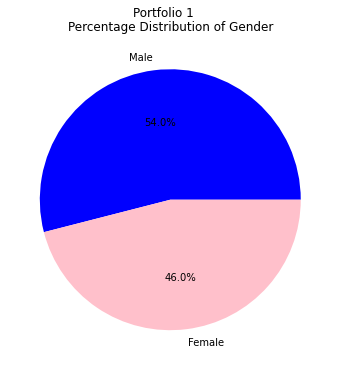

In [31]:
gender_counts = df1['Gender'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', colors=['blue', 'pink'])
plt.title('Percentage Distribution of Gender')
plt.suptitle('Portfolio 1', y=0.95)   
plt.show()

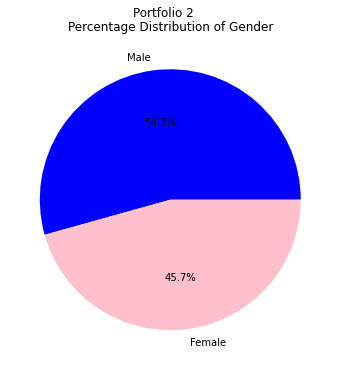

In [32]:
gender_counts = df2['Gender'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', colors=['blue', 'pink'])
plt.title('Percentage Distribution of Gender')
plt.suptitle('Portfolio 2', y=0.95)  
plt.show()

#### Insights: same distribution Male and Female both Portfolios

### Age of clients

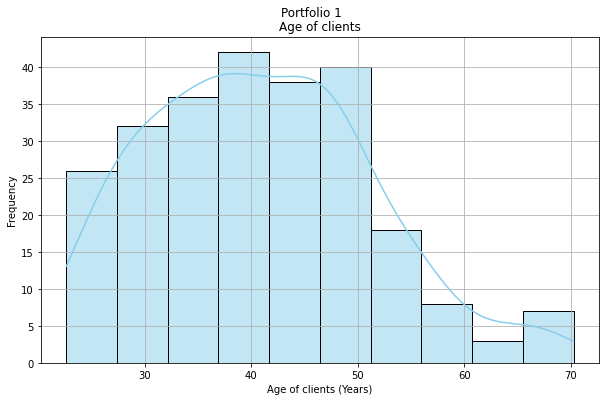

In [33]:
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(df1['age_client_years'], bins=10, kde=True, color='skyblue', edgecolor='black')

plt.title('Age of clients')
plt.suptitle('Portfolio 1', y=0.95)  
plt.xlabel('Age of clients (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

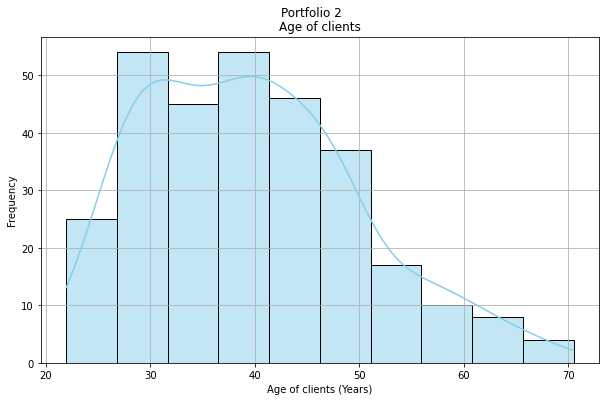

In [34]:
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(df2['age_client_years'], bins=10, kde=True, color='skyblue', edgecolor='black')

plt.title('Age of clients')
plt.suptitle('Portfolio 2', y=0.95)  
plt.xlabel('Age of clients (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Insights: both Portfolos have similar behaviour of ages

### Region in Spain

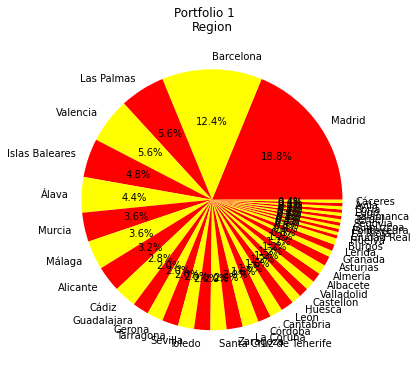

In [35]:
gender_counts = df1['county'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', colors=['red', 'yellow'])
plt.title('Region')
plt.suptitle('Portfolio 1', y=0.95)  
plt.show()

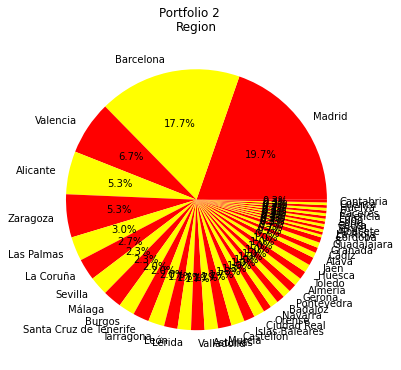

In [36]:
gender_counts = df2['county'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', colors=['red', 'yellow'])
plt.title('Region')
plt.suptitle('Portfolio 2', y=0.95)  
plt.show()

### Insights: There's a slight difference in the Portfolios. 
The weight of Barcelona  in Portfolio 1 is 12% and in Portfolio 2 is 17%
In Portfolio 1, Las Palmas weights 5%. In Portfolio 2 it's 3%

***However, with the data presented, I have no enough information to recommend a Portfolio based on clients' Region***

<font color='blue'> <font size="5">**Further analysis**</font></font> 

### Quality of clients

Based on field ind_good_client

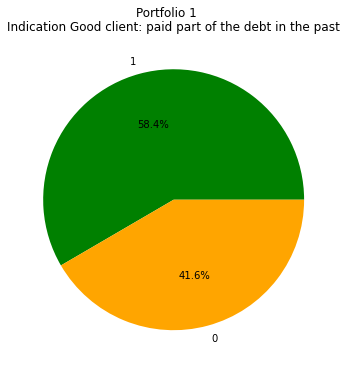

In [38]:
gender_counts = df1['ind_good_client'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', colors=['green', 'orange'])
plt.title('Indication Good client: paid part of the debt in the past')
plt.suptitle('Portfolio 1', y=0.95)  
plt.show()

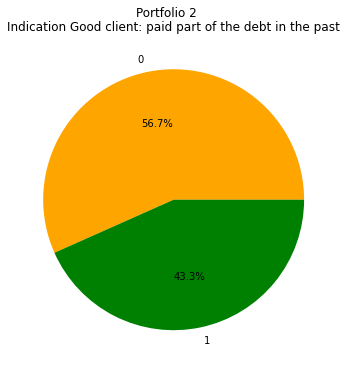

In [39]:
gender_counts = df2['ind_good_client'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', colors=['orange', 'green'])
plt.title('Indication Good client: paid part of the debt in the past')
plt.suptitle('Portfolio 2', y=0.95)  
plt.show()

#### Insight: Portfolio 1 has clients with more willingness to pay the debt in comparison to Portfolio 2

### Size of the Current Balance

In [40]:
df1['new_balance'].sum()

252666.2

In [41]:
df2['new_balance'].sum()

250136.58

####  Average Balance per Client

In [42]:
df1['new_balance'].sum()/len(df1)

1010.6648

In [43]:
df2['new_balance'].sum()/len(df2)

833.7886

#### Insight: Average Balance  per client is higher in Portfolio 1 than Portfolio 2

#### Assumption: the higher the debt, the higher the willingness to pay it

This assumption will be checked based on the data before the default. Comparing about of good clients with high original debt (above median)
and low oriignal debt (below average)

In [44]:
df1['ind_high_original_sum']=np.where(df1.original_sum>df1['original_sum'].median(),1,0)

In [45]:
df2['ind_high_original_sum']=np.where(df2.original_sum>df2['original_sum'].median(),1,0)

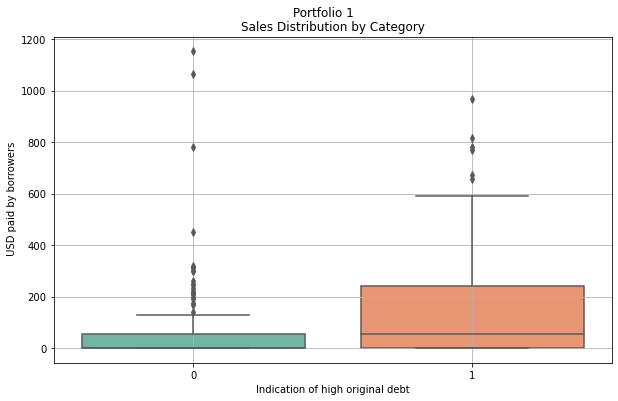

In [46]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=df1['ind_high_original_sum'], y=df1['total_paid'], data=df1, palette="Set2")

plt.title('Sales Distribution by Category')
plt.xlabel('Indication of high original debt')
plt.suptitle('Portfolio 1', y=0.95)  
plt.ylabel(' USD paid by borrowers')
plt.grid(True)
plt.show()

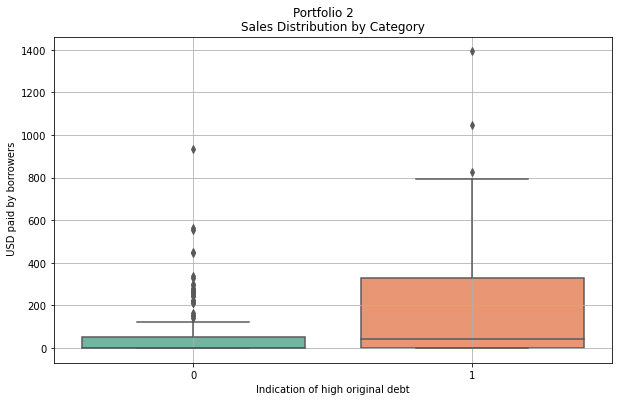

In [47]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=df2['ind_high_original_sum'], y=df2['total_paid'], data=df2, palette="Set2")

plt.title('Sales Distribution by Category')
plt.xlabel('Indication of high original debt')
plt.suptitle('Portfolio 2', y=0.95)  
plt.ylabel(' USD paid by borrowers')

plt.grid(True)

plt.show()

In [65]:
df1.groupby('ind_high_original_sum')['total_paid'].median()

ind_high_original_sum
0     0.000
1    52.845
Name: total_paid, dtype: float64

In [67]:
df1.groupby('ind_high_original_sum')['total_paid'].quantile(0.75)

ind_high_original_sum
0     54.6450
1    240.5525
Name: total_paid, dtype: float64

In [66]:
df2.groupby('ind_high_original_sum')['total_paid'].median()

ind_high_original_sum
0     0.0
1    44.3
Name: total_paid, dtype: float64

In [68]:
df2.groupby('ind_high_original_sum')['total_paid'].quantile(0.75)

ind_high_original_sum
0     52.685
1    328.550
Name: total_paid, dtype: float64

### Insight: In both Portfolios (before default). The higher the debt, the higher the amount recovered

In both Portfolios, the boxplot of high_debts are above than boxplot of low_debts.

The difference can be seen in the graphs above and highlighted the values of median and percentile 75%

Therefore, clients aims to pay higher debt in comparison to small debts

### Tenure of the default

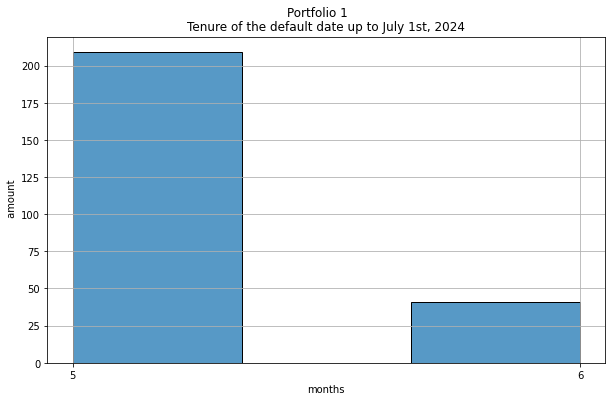

In [48]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot with a custom color palette
sns.histplot(x=df1['age_debt_months'], bins=3)


# Add title and axis labels
plt.title('Tenure of the default date up to July 1st, 2024')
plt.xlabel('months')
plt.suptitle('Portfolio 1', y=0.95)  
plt.ylabel(' amount')

# Add gridlines
plt.grid(True)

max_age = df1['age_debt_months'].max()
plt.xticks(range(5, max_age + 1))

# Display the plot
plt.show()

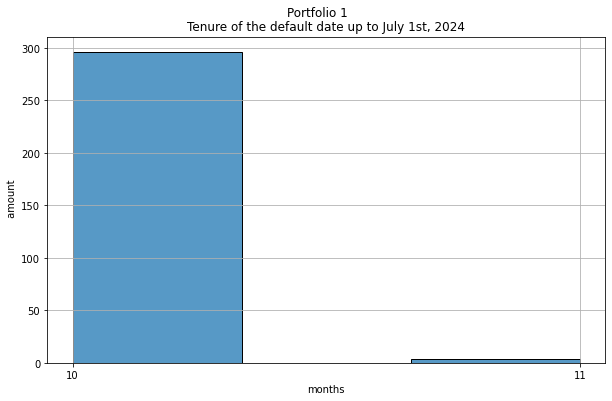

In [49]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot with a custom color palette
sns.histplot(x=df2['age_debt_months'], bins=3)


# Add title and axis labels
plt.title('Tenure of the default date up to July 1st, 2024')
plt.xlabel('months')
plt.suptitle('Portfolio 1', y=0.95)  
plt.ylabel(' amount')

# Add gridlines
plt.grid(True)

max_age = df2['age_debt_months'].max()
plt.xticks(range(10, max_age + 1))

# Display the plot
plt.show()

### Insights: Portfolio 1 the default is "newer". 

Assuming, clients tend to prioritize new debts in comparison to old debts. Most of debts in Portfolio 1 have age of 5 months vs 10 months in Portfolio 2


### Interest Rate

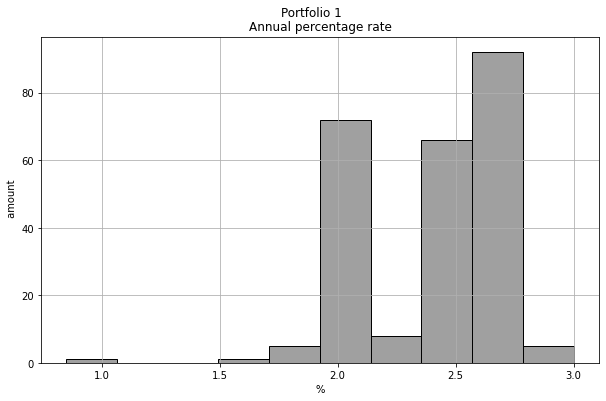

In [50]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot with a custom color palette
sns.histplot(x=df1['apr'], bins=10,color='gray')


# Add title and axis labels
plt.title('Annual percentage rate')
plt.xlabel('%')
plt.suptitle('Portfolio 1', y=0.95)  
plt.ylabel(' amount')

# Add gridlines
plt.grid(True)


# Display the plot
plt.show()

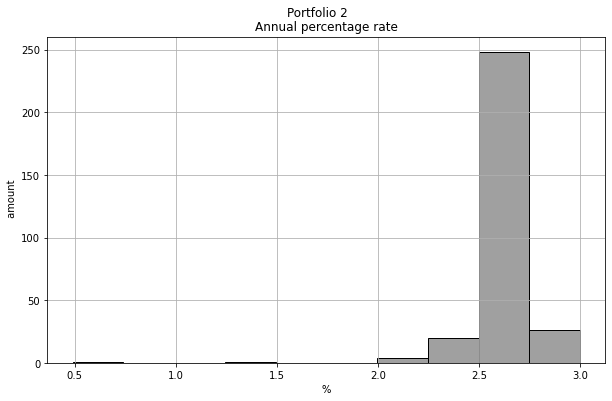

In [51]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot with a custom color palette
sns.histplot(x=df2['apr'], bins=10,color='gray')


# Add title and axis labels
plt.title('Annual percentage rate')
plt.xlabel('%')
plt.suptitle('Portfolio 2', y=0.95)  
plt.ylabel(' amount')

# Add gridlines
plt.grid(True)


# Display the plot
plt.show()

In [52]:
df1['apr'].describe()

count    250.000000
mean       2.374137
std        0.290747
min        0.850800
25%        2.040000
50%        2.400000
75%        2.640000
max        3.000000
Name: apr, dtype: float64

In [53]:
df2['apr'].describe()

count    300.000000
mean       2.633486
std        0.200918
min        0.489600
25%        2.640000
50%        2.640000
75%        2.640000
max        3.000000
Name: apr, dtype: float64

#### Insights:

Although Portfolio 1 has lower interest rates (median of 2.4% vs 2.6% in Poetfolio 2), 
considering in yearly basis, this difference is not significant. 

<font color='blue'> <font size="6">**Recommendation**</font></font> 

Assuming both Porfolios have same price, the recommendation is to buy **Portfolio 1** because the reasons below:

   
    - Better quality of the clients (58% in Portfolio 1 are good clients vs 43% in Portfolio 2).
    - Higher average of balance per client ( USD 1,010 in Portfolio 1 and USD 833 in Portfolio 2). According to analysis before the default: the higher the debt per client, the higher the probability to pay part of the debt.
    - the debts in default are newer (5 months vs 10 months).

